In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA


## Loading

In [2]:
dataset_folder = '../data/GPVS-Faults'

filenames = os.listdir(dataset_folder)

class_names = [filename[:3] for filename in filenames]

le = LabelEncoder()
le.fit(class_names)
print(le.classes_)

['F0L' 'F0M' 'F1L' 'F1M' 'F2L' 'F2M' 'F3L' 'F3M' 'F4L' 'F4M' 'F5L' 'F5M'
 'F6L' 'F6M' 'F7L' 'F7M']


In [4]:

path = '../data/GPVS-Faults/F0L.mat'

with h5py.File(path, 'r') as f:
    def print_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            shape = obj.shape
            dtype = obj.dtype
            if len(shape) > 0:
                print(f"🔹 {name:40s} shape={shape} dtype={dtype}")
    f.visititems(print_dataset)


🔹 #refs#/A                                 shape=(2, 1) dtype=uint16
🔹 #refs#/B                                 shape=(2, 1) dtype=uint16
🔹 #refs#/C                                 shape=(2, 1) dtype=uint16
🔹 #refs#/D                                 shape=(2, 1) dtype=uint16
🔹 #refs#/E                                 shape=(2, 1) dtype=uint16
🔹 #refs#/F                                 shape=(2, 1) dtype=uint16
🔹 #refs#/G                                 shape=(4, 1) dtype=uint16
🔹 #refs#/H                                 shape=(2, 1) dtype=uint16
🔹 #refs#/I                                 shape=(4, 1) dtype=uint16
🔹 #refs#/J                                 shape=(2, 1) dtype=uint16
🔹 #refs#/K/CustomProps                     shape=(2,) dtype=uint64
🔹 #refs#/K/Description                     shape=(2,) dtype=uint64
🔹 #refs#/K/DimensionNames                  shape=(2, 1) dtype=object
🔹 #refs#/K/DimensionNamesOriginal          shape=(2,) dtype=uint64
🔹 #refs#/K/UserData                     

In [5]:
path = '../data/GPVS-Faults/F0L.mat'

with h5py.File(path, 'r') as f:
    # from D to Q 14 columns
    keys = [k for k in f['#refs#'].keys() if k >= 'd' and k <= 'q']
    data_arrays = [np.array(f['#refs#/'+ k]).ravel() for k in keys]
    data = np.vstack(data_arrays).T 
    print("shape:", data.shape)

    # the name of each column
    
    names = []
    for ref in f['#refs#/v']:## v variable name
        obj = f[ref[0]]
        s = obj[:].tobytes().decode('utf-16', errors='ignore').strip('\x00')
        names.append(s)
    

F0L = pd.DataFrame(data, columns=names)
print(F0L.head())
print(F0L.shape)

shape: (143715, 14)
       Time       Ipv         Vpv         Vdc        ia        ib        ic  \
0  0.000028  1.572327  101.348877  144.140625 -0.135133  0.490112 -0.354985   
1  0.000128  1.503265  101.458740  143.554688 -0.108277  0.510254 -0.388555   
2  0.000228  1.492859  101.574707  143.554688 -0.168702  0.496826 -0.334844   
3  0.000328  1.558136  101.312256  143.261719 -0.135133  0.510254 -0.361699   
4  0.000428  1.631927  101.141357  143.847656 -0.202271  0.503540 -0.321416   

          va          vb          vc  Iabc    If  Vabc    Vf  
0  41.744537 -149.872894  109.064585   1.0  50.0   1.0  50.0  
1  46.831512 -150.716705  105.829976   1.0  50.0   1.0  50.0  
2  51.074677 -152.018585  102.543132   1.0  50.0   1.0  50.0  
3  55.848236 -152.585144   98.143260   1.0  50.0   1.0  50.0  
4  60.055237 -152.609253   94.261729   1.0  50.0   1.0  50.0  
(143715, 14)


In [ ]:
F0L

In [6]:
def read_mat_file(path, label):
    with h5py.File(path, 'r') as f:
        # from D to Q 14 columns
        keys = [k for k in f['#refs#'].keys() if 'd' <= k <= 'q']
        data_arrays = [np.array(f['#refs#/' + k]).ravel() for k in keys]
        data = np.vstack(data_arrays).T

        # the name of each column
        names = []
        for ref in f['#refs#/v']:
            obj = f[ref[0]]
            s = obj[:].tobytes().decode('utf-16', errors='ignore').strip('\x00')
            names.append(s)

    df = pd.DataFrame(data, columns=names)
    df["label"] = label
    print(f"{label} loaded, shape = {df.shape}")
    return df

In [7]:
F0L = read_mat_file("../data/GPVS-Faults/F0L.mat", "F0L")
F1L = read_mat_file("../data/GPVS-Faults/F1L.mat", "F1L")
F2L = read_mat_file("../data/GPVS-Faults/F2L.mat", "F2L")
F3L = read_mat_file("../data/GPVS-Faults/F3L.mat", "F3L")
F4L = read_mat_file("../data/GPVS-Faults/F4L.mat", "F4L")
F5L = read_mat_file("../data/GPVS-Faults/F5L.mat", "F5L")
F6L = read_mat_file("../data/GPVS-Faults/F6L.mat", "F6L")
F7L = read_mat_file("../data/GPVS-Faults/F7L.mat", "F7L")
F0M = read_mat_file("../data/GPVS-Faults/F0L.mat", "F0M")
F1M = read_mat_file("../data/GPVS-Faults/F1L.mat", "F1M")
F2M = read_mat_file("../data/GPVS-Faults/F2L.mat", "F2M")
F3M = read_mat_file("../data/GPVS-Faults/F3L.mat", "F3M")
F4M = read_mat_file("../data/GPVS-Faults/F4L.mat", "F4M")
F5M = read_mat_file("../data/GPVS-Faults/F5L.mat", "F5M")
F6M = read_mat_file("../data/GPVS-Faults/F6L.mat", "F6M")
F7M = read_mat_file("../data/GPVS-Faults/F7L.mat", "F7M")
print(F0L.head())

F0L loaded, shape = (143715, 15)
F1L loaded, shape = (129013, 15)
F2L loaded, shape = (142128, 15)
F3L loaded, shape = (103497, 15)
F4L loaded, shape = (144014, 15)
F5L loaded, shape = (143015, 15)
F6L loaded, shape = (144015, 15)
F7L loaded, shape = (144015, 15)
F0M loaded, shape = (143715, 15)
F1M loaded, shape = (129013, 15)
F2M loaded, shape = (142128, 15)
F3M loaded, shape = (103497, 15)
F4M loaded, shape = (144014, 15)
F5M loaded, shape = (143015, 15)
F6M loaded, shape = (144015, 15)
F7M loaded, shape = (144015, 15)
       Time       Ipv         Vpv         Vdc        ia        ib        ic  \
0  0.000028  1.572327  101.348877  144.140625 -0.135133  0.490112 -0.354985   
1  0.000128  1.503265  101.458740  143.554688 -0.108277  0.510254 -0.388555   
2  0.000228  1.492859  101.574707  143.554688 -0.168702  0.496826 -0.334844   
3  0.000328  1.558136  101.312256  143.261719 -0.135133  0.510254 -0.361699   
4  0.000428  1.631927  101.141357  143.847656 -0.202271  0.503540 -0.321416  

In [8]:
# Combine all files
solar_power = pd.concat([F0L, F1L, F2L, F3L, F4L, F5L, F6L, F7L,F0M, F1M, F2M, F3M, F4M, F5M, F6M, F7M], ignore_index=True)
# Combine all L files
solar_Lim_power = pd.concat([F0L, F1L, F2L, F3L, F4L, F5L, F6L, F7L], ignore_index=True)
# Combine all M files
solar_Max_power = pd.concat([F0M, F1M, F2M, F3M, F4M, F5M, F6M, F7M], ignore_index=True)

## Pairplot Visualization of PV System Variables (Sampled Every 1000 Points)

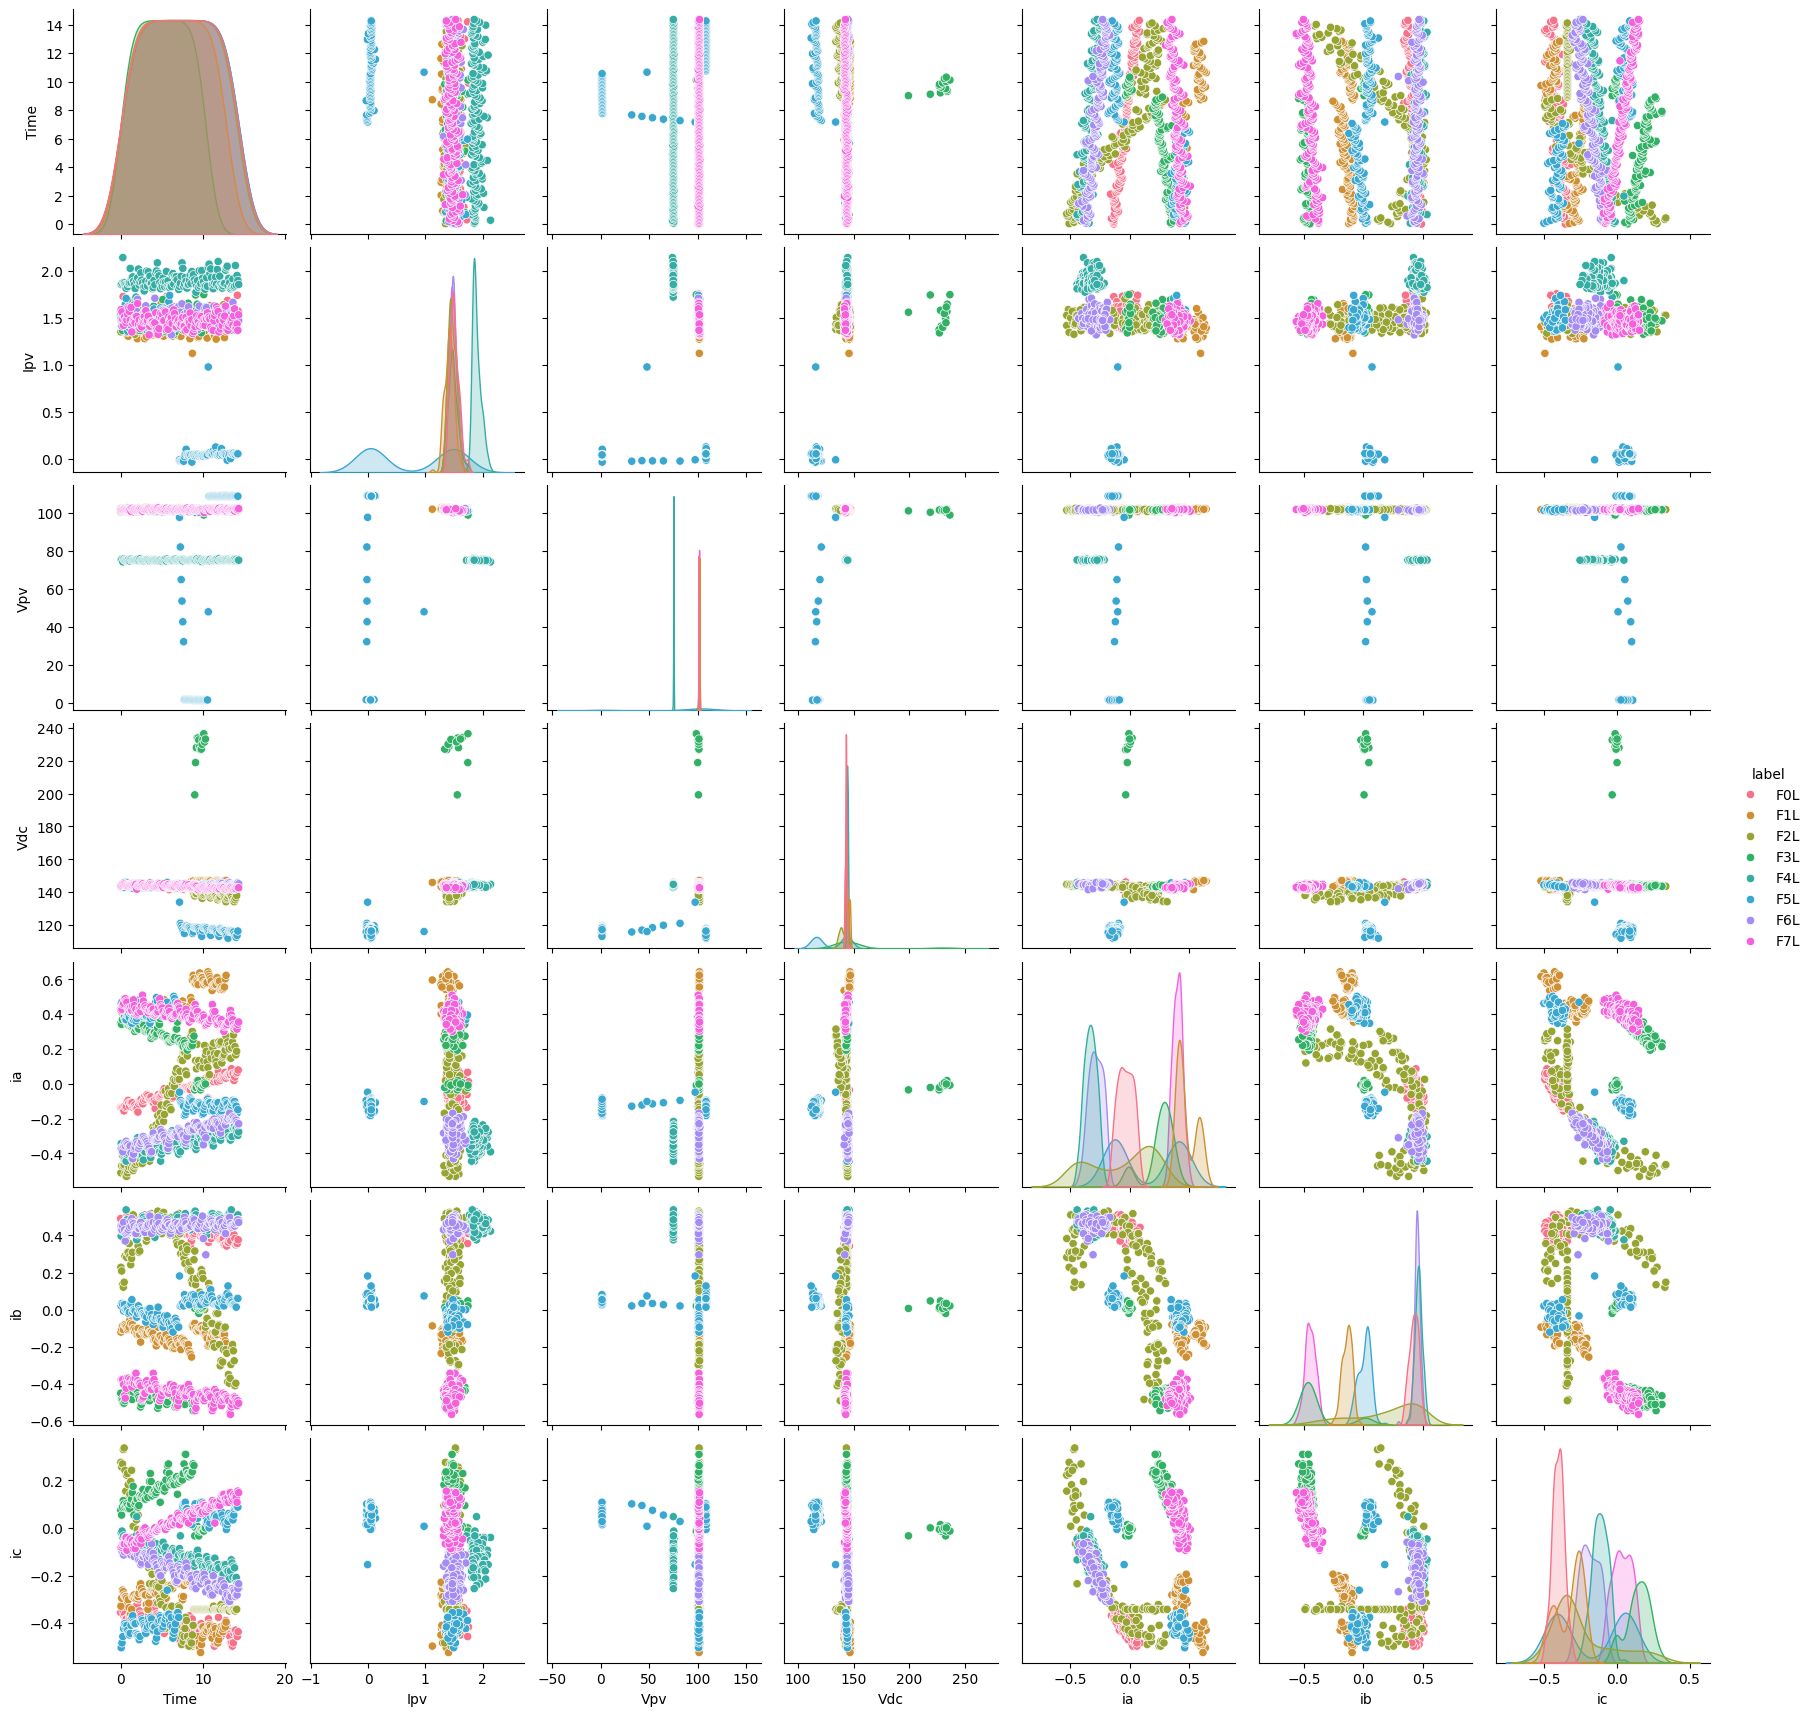

In [9]:
# Pairplot of Limiting power dataset
solar_Lim_power1= solar_Lim_power.iloc[::1000,:]
sns.pairplot(solar_Lim_power1[['Time','Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'label']], hue='label', palette='husl')
plt.show()

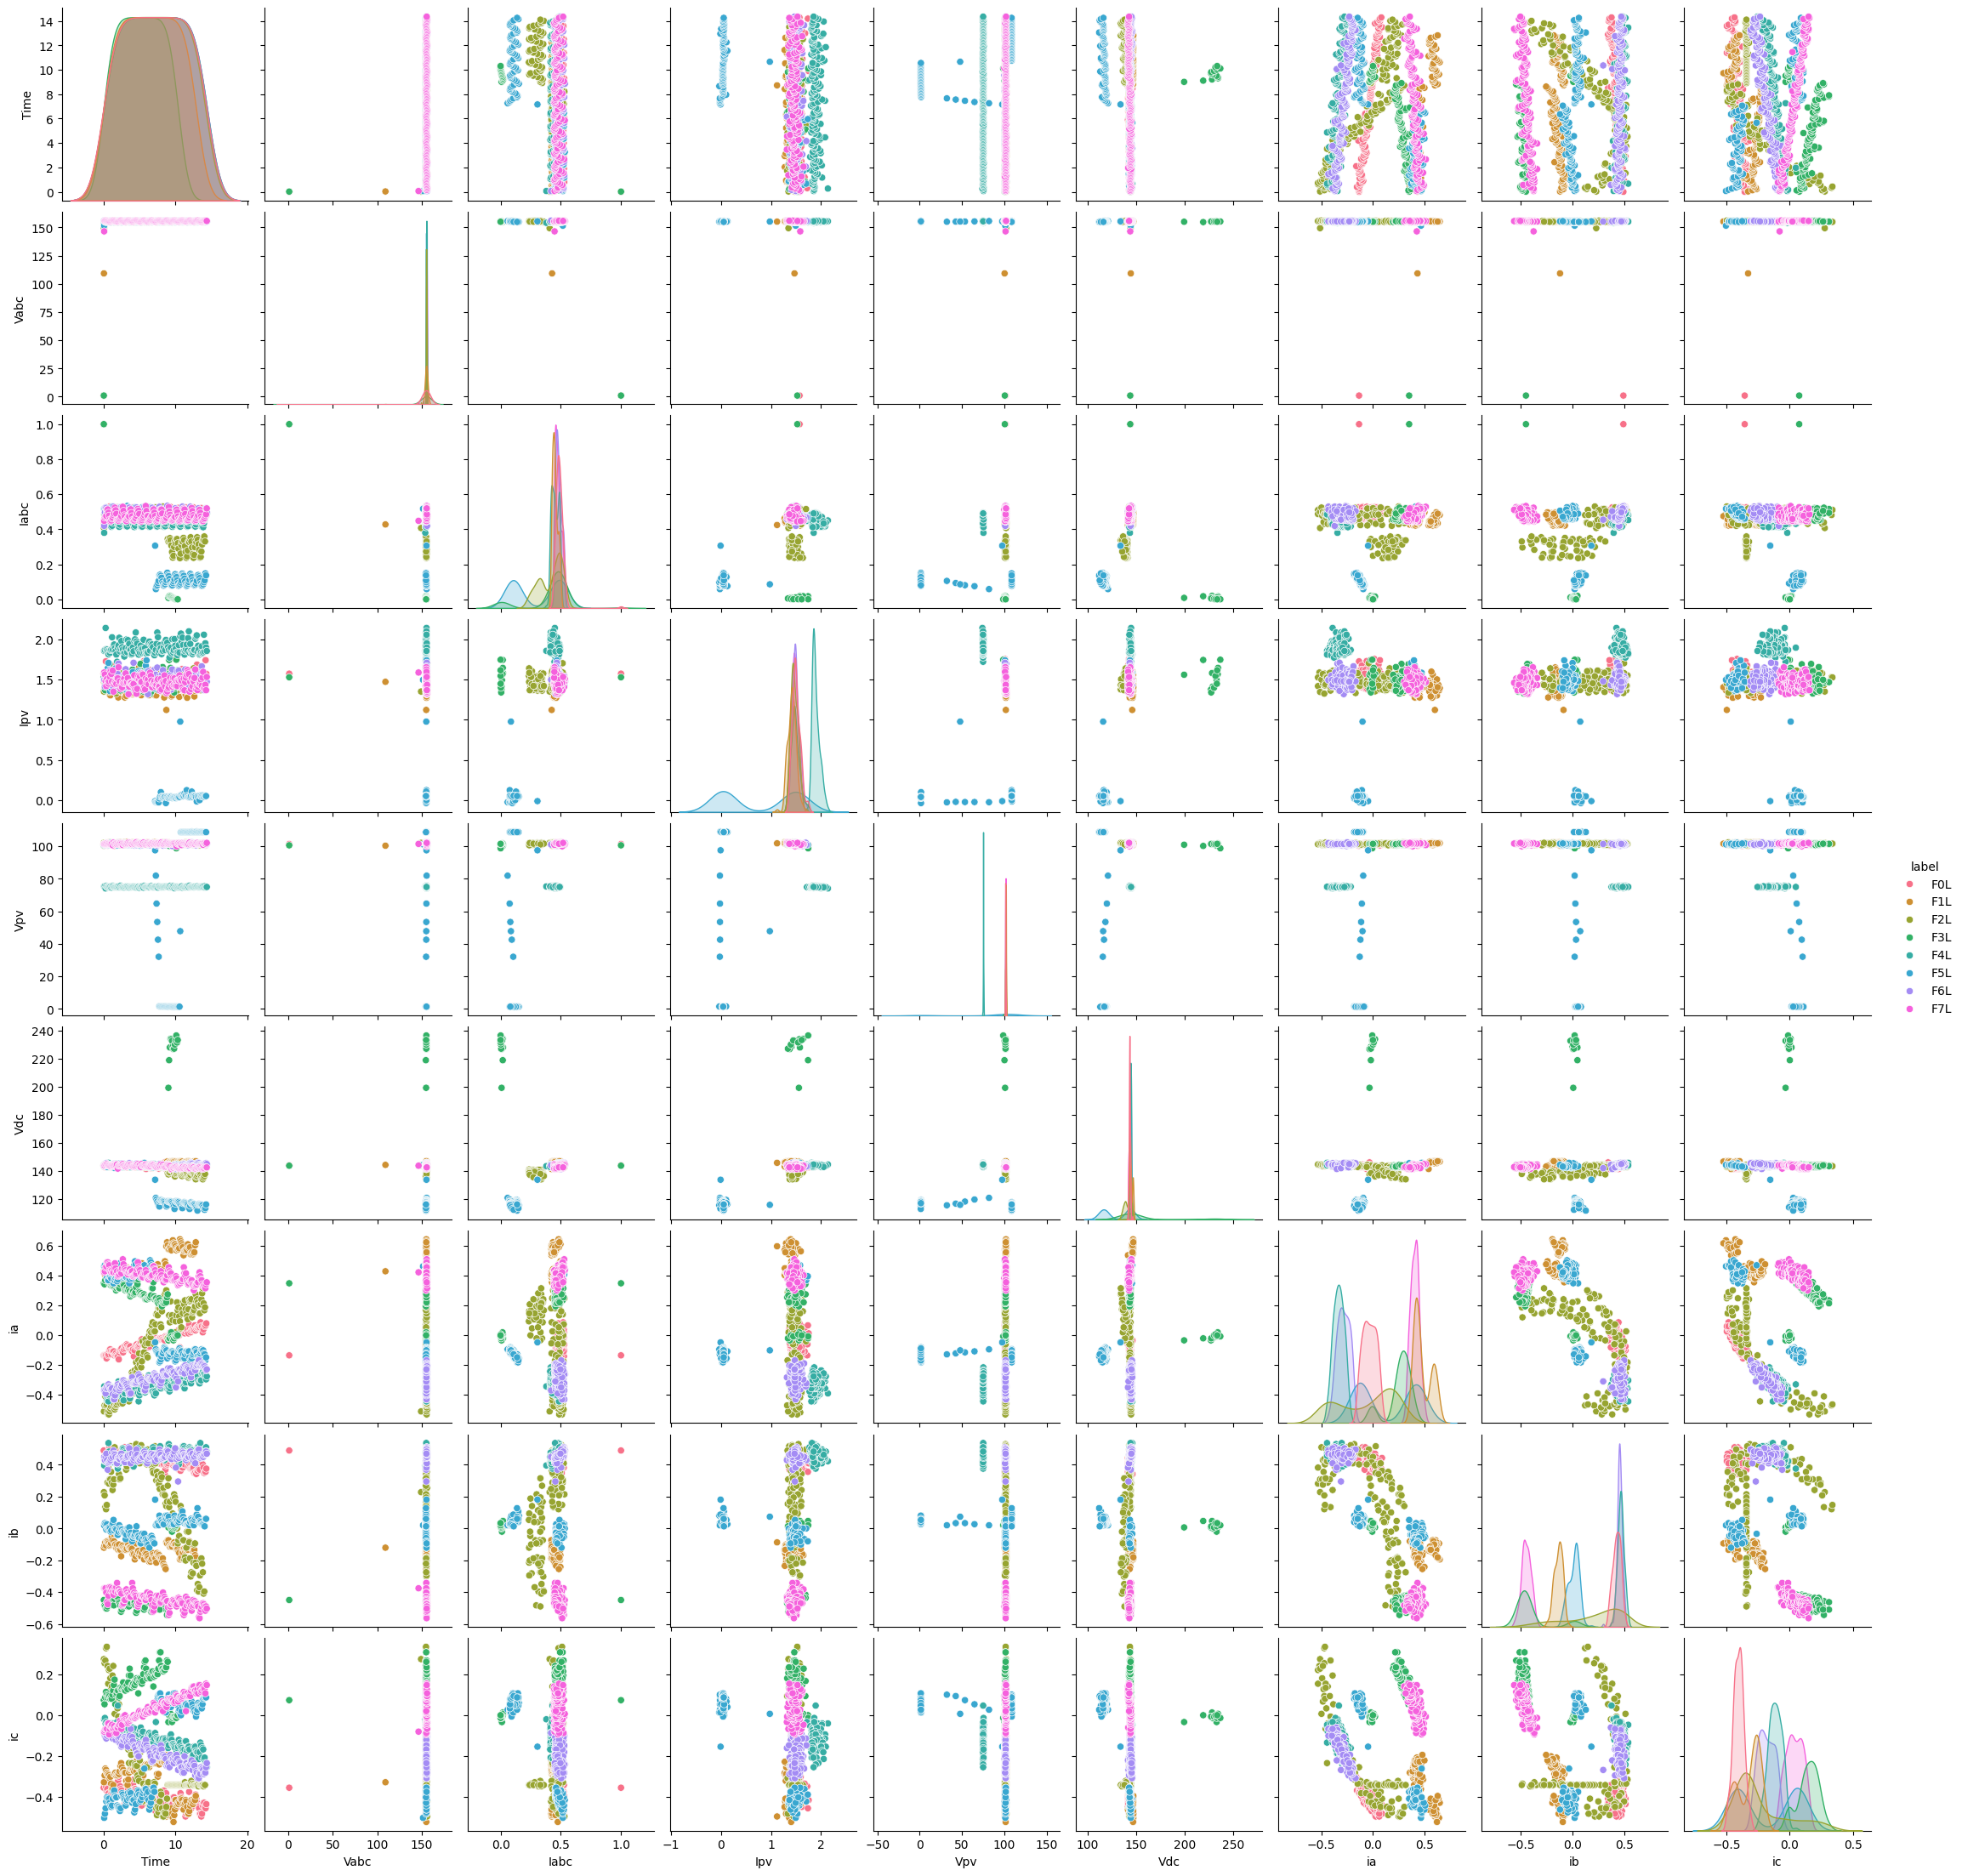

In [27]:
# Pairplot of Maximum power dataset
solar_Max_power1= solar_Max_power.iloc[::1000,:]
sns.pairplot(solar_Lim_power1[['Time','Vabc','Iabc' , 'Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'label']], hue='label', palette='husl')
plt.show()

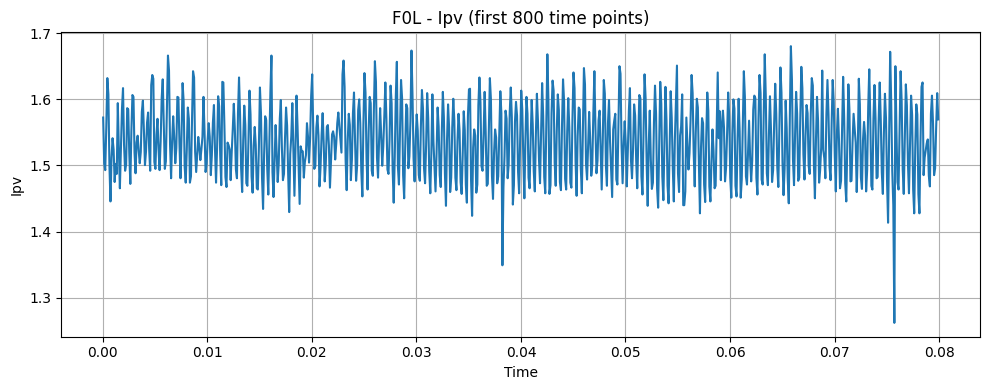

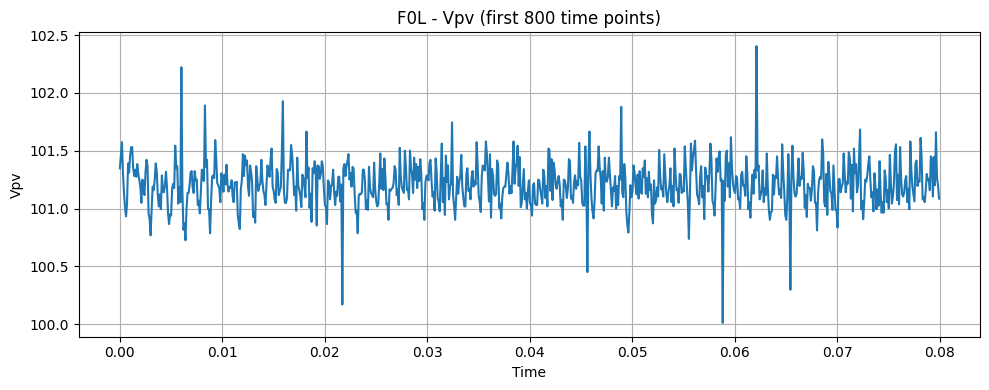

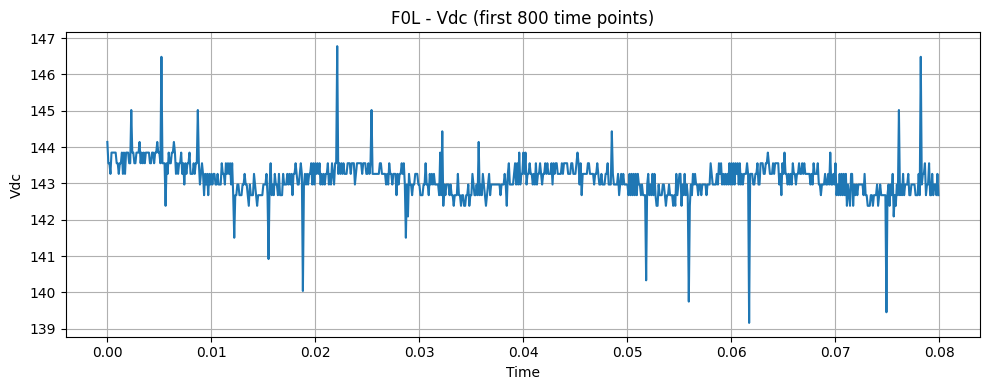

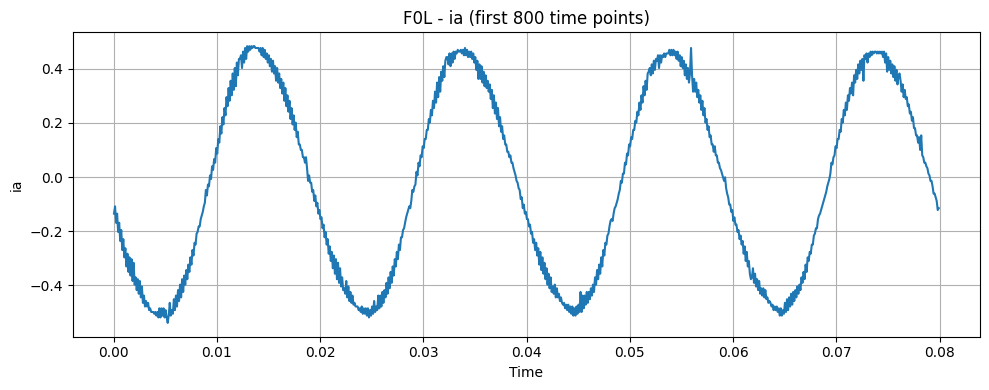

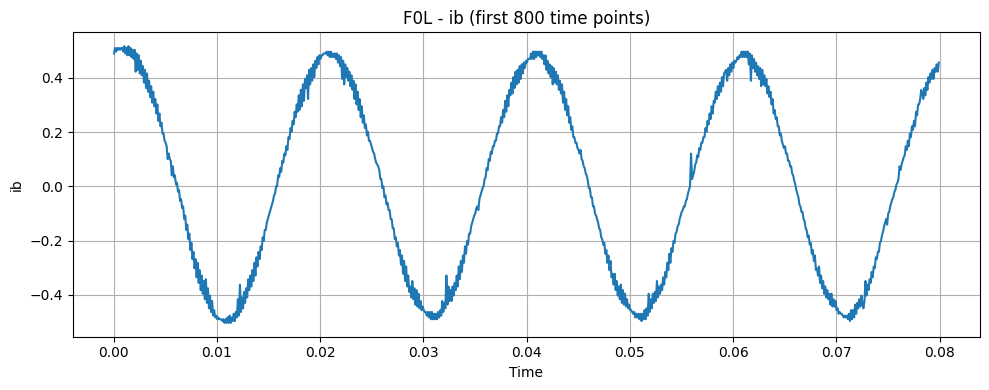

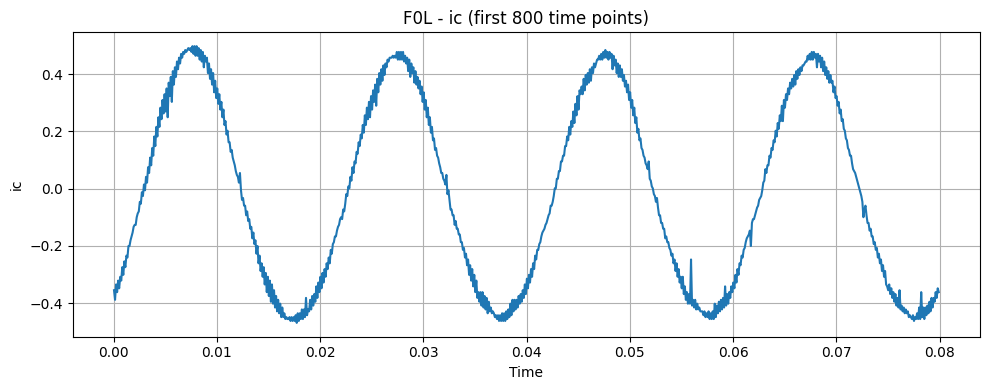

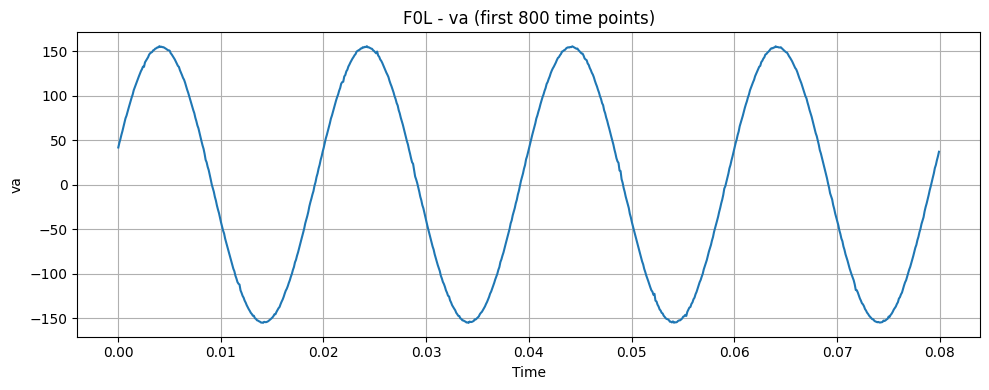

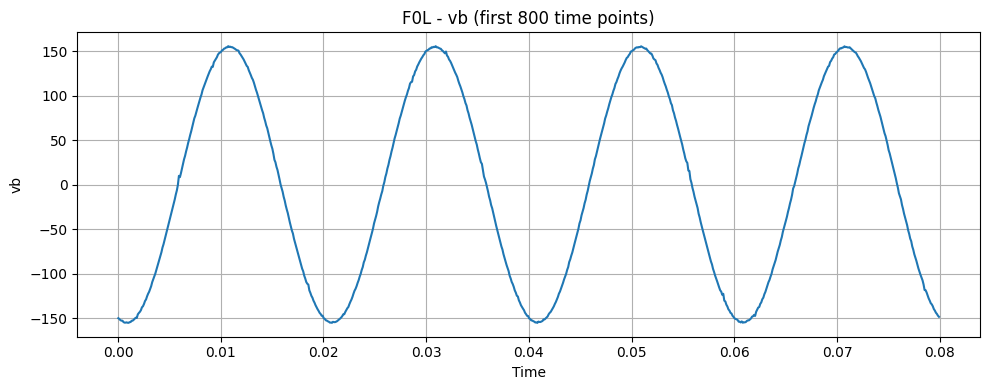

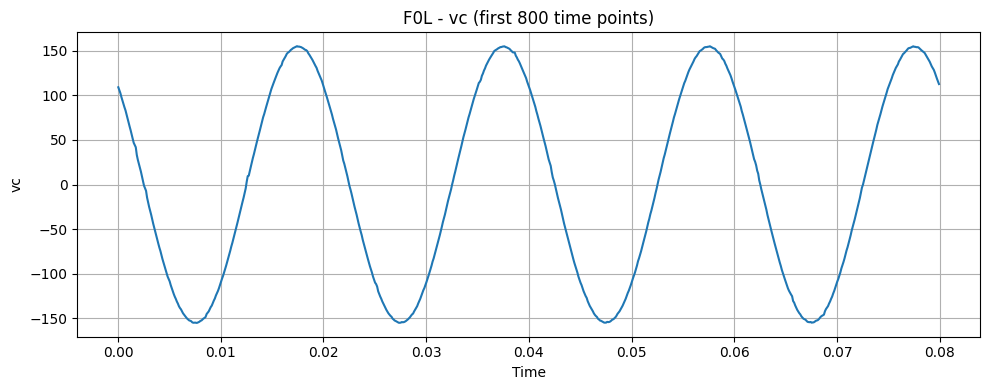

In [11]:
def plot_each_variable(df, variables, first_point=0, n_points=256):
    
    for var in variables:
        plt.figure(figsize=(10, 4))
        plt.plot(df['Time'][first_point:n_points + first_point], df[var][first_point :n_points + first_point], color='tab:blue')
        plt.title(f"{df['label'].iloc[0]} - {var} (first {n_points} time points)")
        plt.xlabel("Time")
        plt.ylabel(var)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_each_variable(
    F0L,
    ['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc'],
    #first_point=5000,
    n_points=800  # You can change to 512, 1024, etc.
)

## IQR / MAE

In [ ]:
def detect_outliers_iqr(x, k=1.5):
  
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (x < lower) | (x > upper)

def mad_mask(x, c=3.5):
    """
    基于 MAD 的稳健 z-score 检测异常：|z|>c 记为异常（默认 c=3.5 较保守）。
    返回布尔掩码（True=异常）。
    """
    x = np.asarray(x, dtype=float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad == 0:  # 全部一样或几乎不变时，认为无异常
        return np.zeros_like(x, dtype=bool)
    z = 0.6745 * (x - med) / mad   # 0.6745≈将MAD标准化到~N(0,1)
    return np.abs(z) > c



##  Replace with Cubic Spline / Linear

In [ ]:
def replace_with_cubic_spline(x, mask, t):
    # NOTE:
        # When using the standard cubic spline interpolation for variable Vabc,
        # an overshoot (spike) occurs near t → 0 due to spline boundary effects.
        # To avoid this instability, we replace the standard spline with PCHIP
        # (Piecewise Cubic Hermite Interpolating Polynomial), which is still cubic
        # but preserves monotonicity and prevents overshoot at the boundaries.
    x, t, m = np.asarray(x,float), np.asarray(t,float), np.asarray(mask,bool)
    if not m.any(): return x
    i = np.argsort(t); t, x, m = t[i], x[i], m[i]
    keep = ~m
    if keep.sum() < 4:                      # too few points → linear
        x[m] = np.interp(t[m], t[keep], x[keep]); return x[np.argsort(i)]
    try:
        f = PchipInterpolator(t[keep], x[keep], extrapolate=False)
        y = x.copy(); y[m] = f(t[m])
        nanm = m & np.isnan(y); 
        if nanm.any(): y[nanm] = np.interp(t[nanm], t[keep], x[keep])
        return y[np.argsort(i)]
    except:                                  # any failure → linear
        x[m] = np.interp(t[m], t[keep], x[keep]); return x[np.argsort(i)]



def replace_with_linear(x, mask, x_axis):
    
    y = np.asarray(x, dtype=float).copy()
    if not np.any(mask):
        return y

    xi = np.asarray(x_axis, dtype=float)

    keep = ~mask
    
    y[mask] = np.interp(xi[mask], xi[keep], y[keep])
    return y


In [14]:
def detect_outliers(x, k=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (x < lower) | (x > upper)

def replace_outliers_local_mean(x, window=11):
    """
    Replace outlier points with centered rolling mean.
    Returns replaced array and boolean mask of outliers.
    """
    x = np.asarray(x, dtype=float).copy()
    mask = detect_outliers(x)
    if not mask.any():
        return x, mask
    wl = int(window)
    if wl < 3: wl = 3
    if wl % 2 == 0: wl += 1
    ser = pd.Series(x)
    roll = ser.rolling(window=wl, center=True, min_periods=1).mean().values
    x[mask] = roll[mask]
    return x, mask

[MAD + CubicSpline] Total replacements: 16579


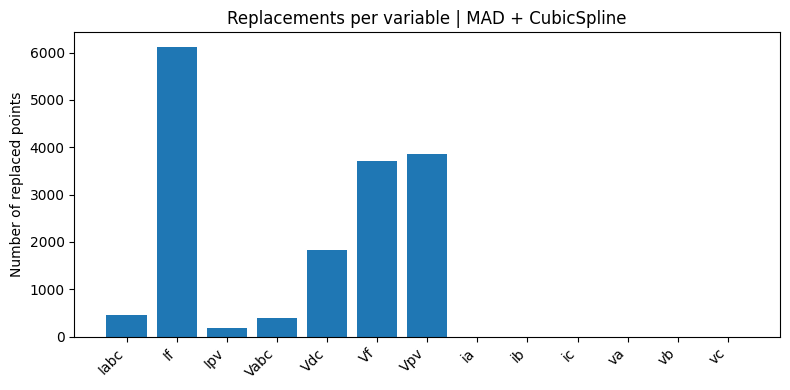

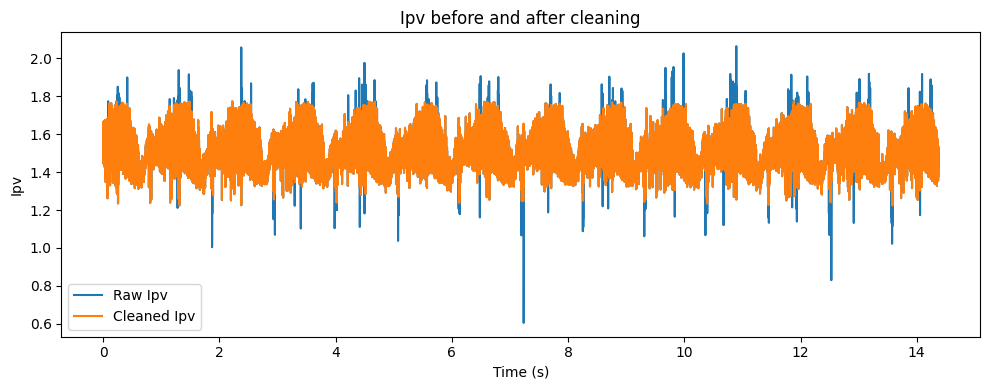

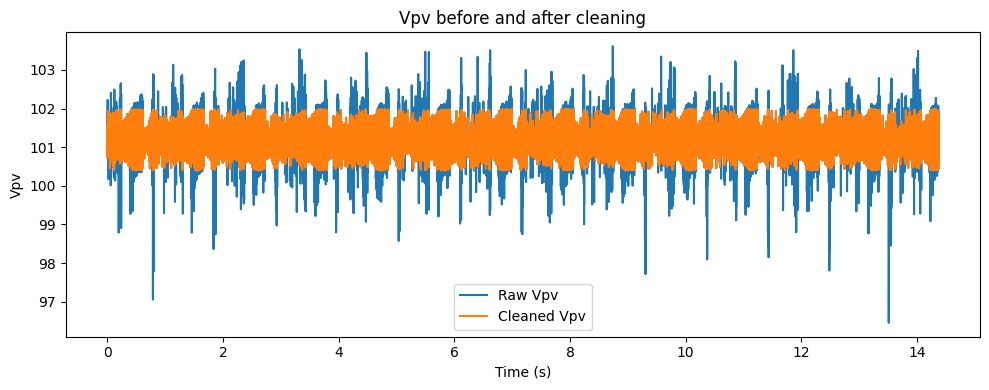

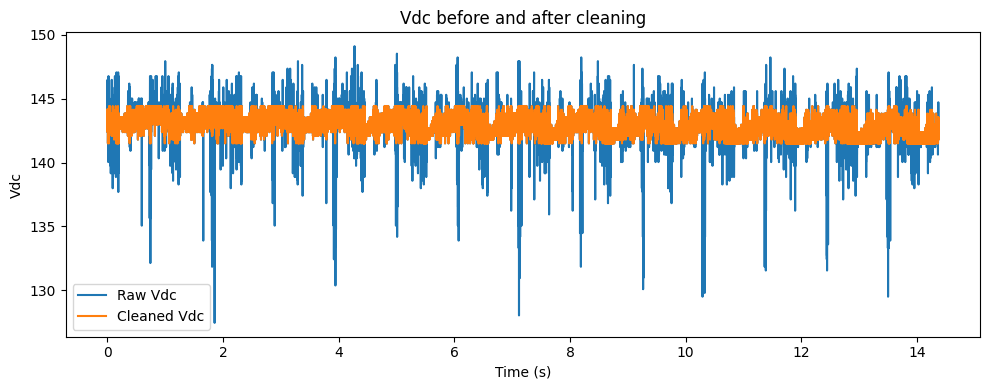

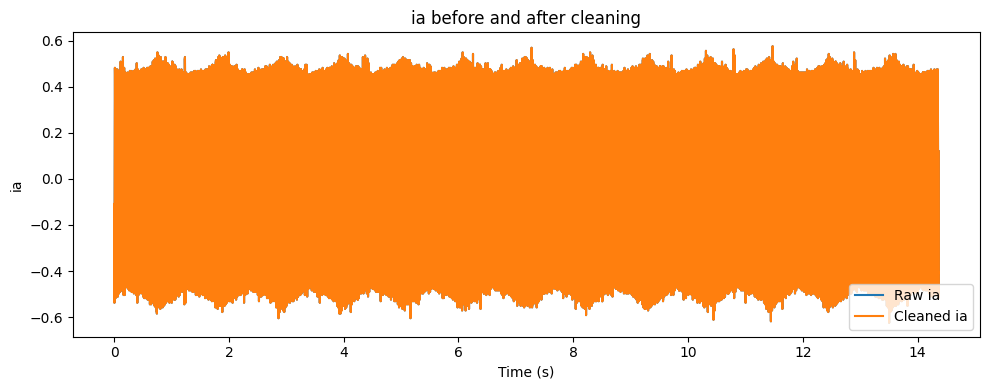

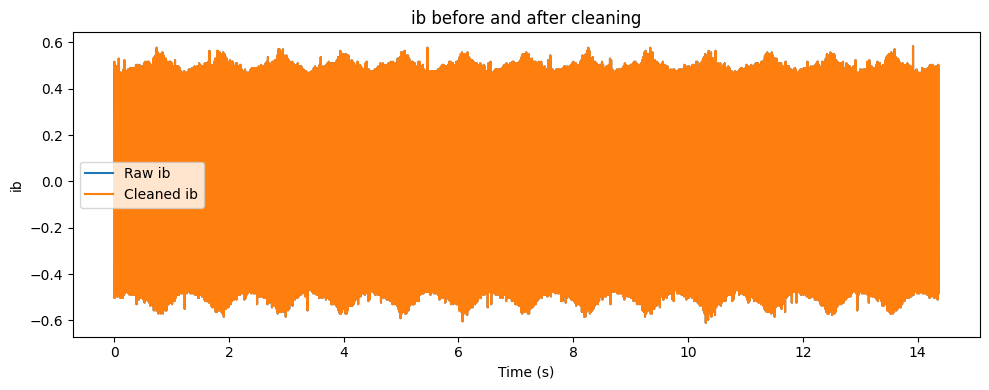

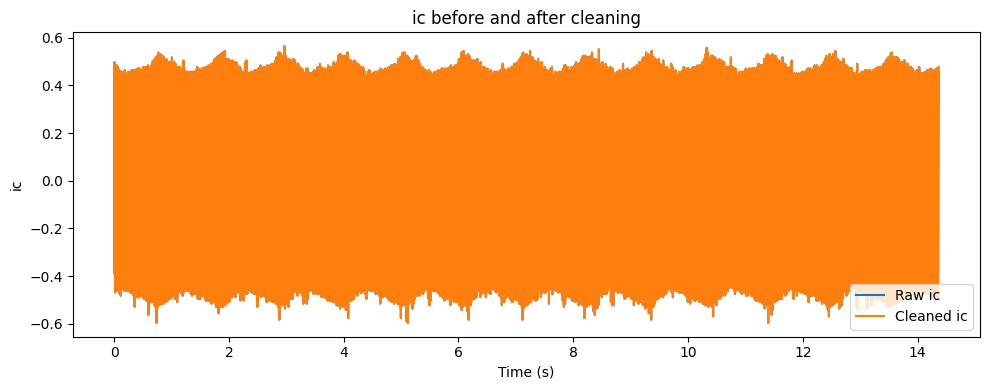

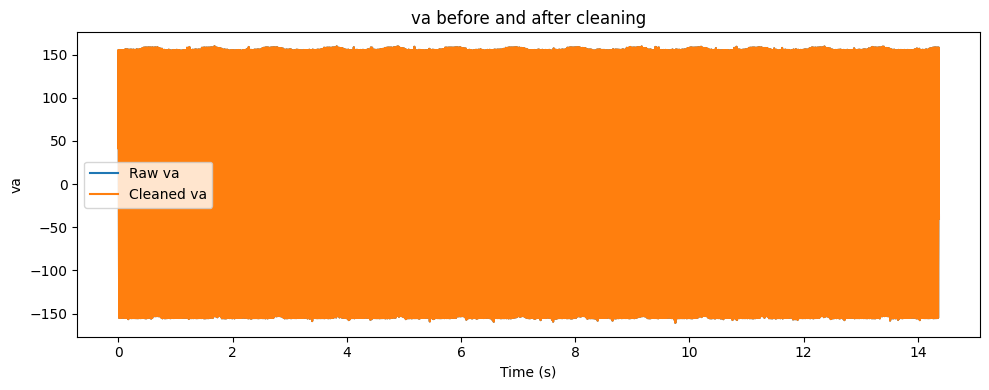

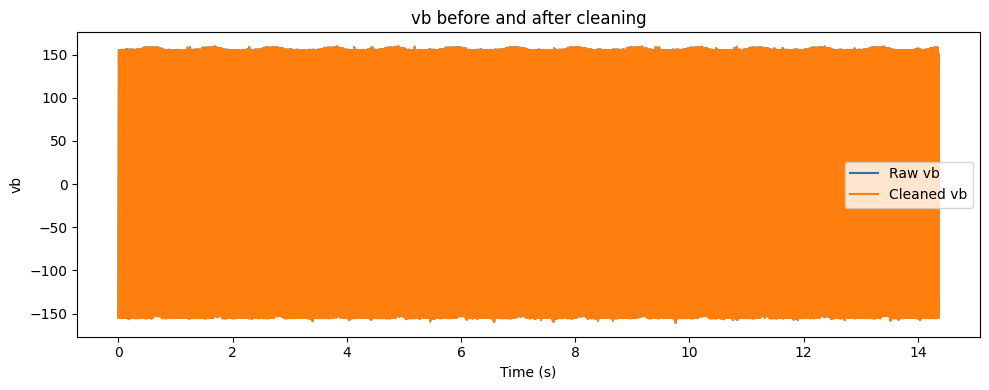

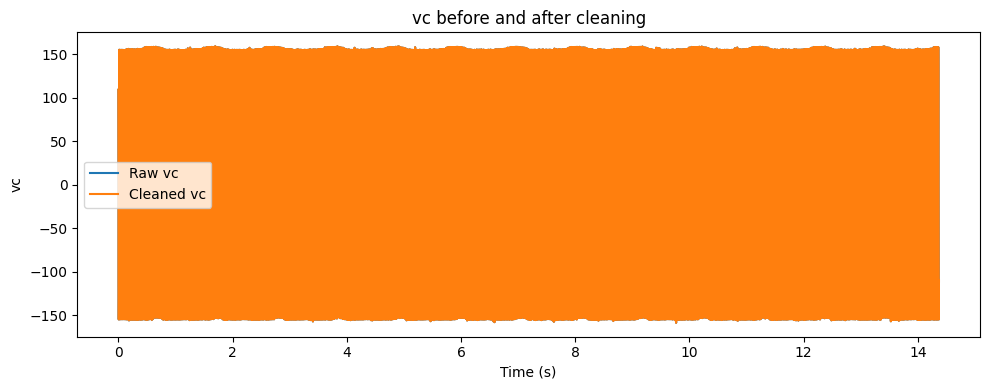

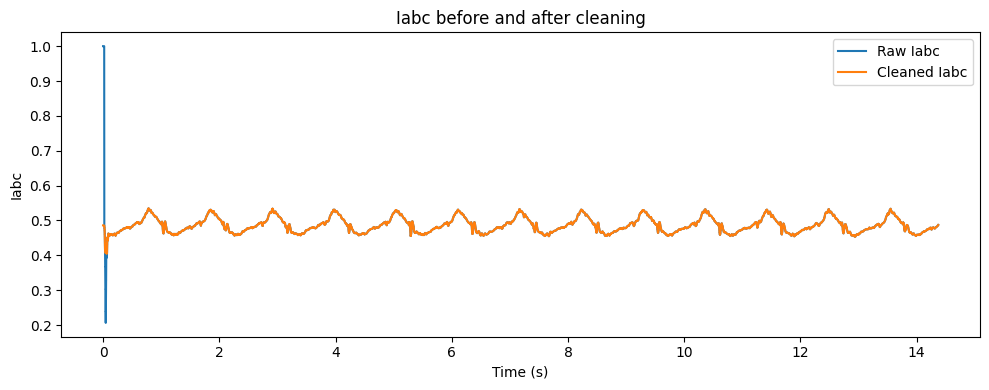

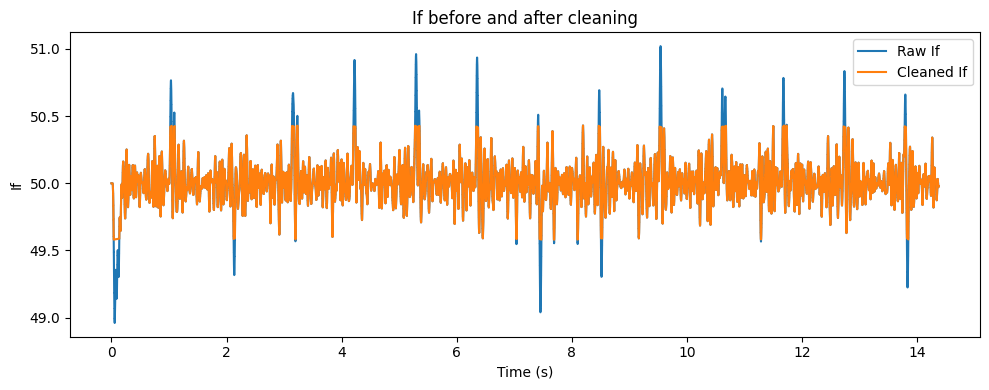

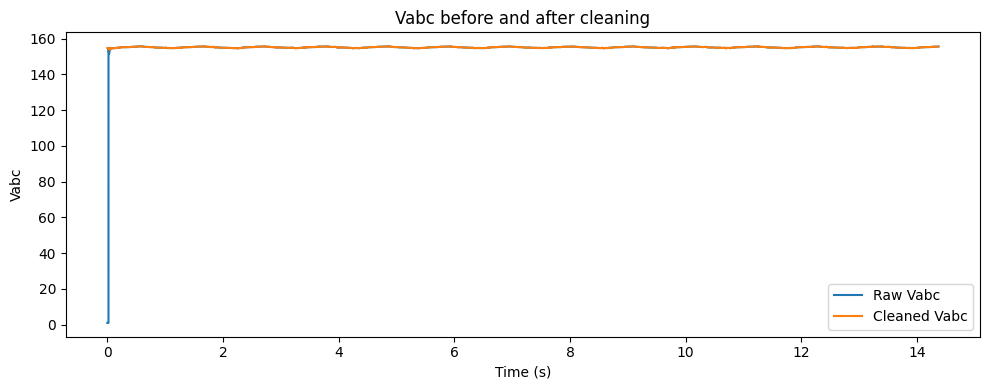

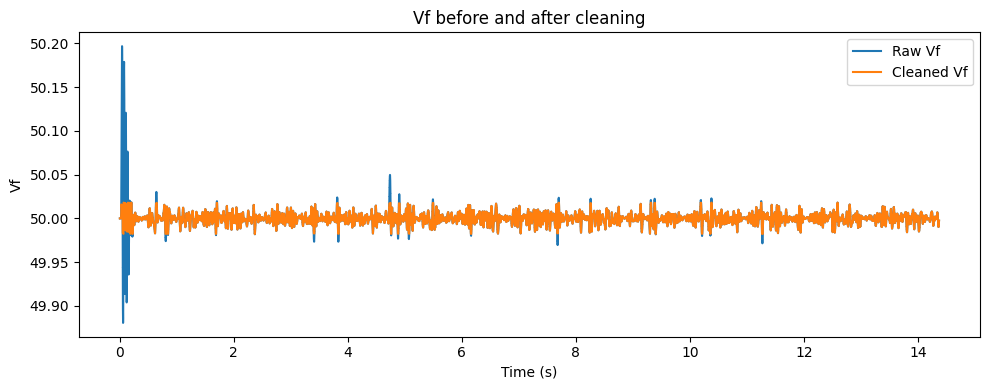

In [42]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

#Choose methods 
DET_NAME = "MAD"          # Options: "MAD" or "IQR"
REP_NAME = "CubicSpline"  # Options: "CubicSpline" or "Linear"

DETECTORS = {"MAD": mad_mask, "IQR": detect_outliers_iqr}
REPLACERS = {"CubicSpline": replace_with_cubic_spline, "Linear": replace_with_linear}
detector, replacer = DETECTORS[DET_NAME], REPLACERS[REP_NAME]


num_cols = [c for c in F0L.select_dtypes(include=[np.number]).columns if c not in ("Time",)]
x_axis = F0L["Time"].values if "Time" in F0L.columns else np.arange(len(F0L))


F0L_clean = F0L.copy()
counts = {}
for c in num_cols:
    x = F0L_clean[c].values
    mask = detector(x)
    counts[c] = int(mask.sum())
    if counts[c] > 0:
        F0L_clean[c] = replacer(x, mask, x_axis)

print(f"[{DET_NAME} + {REP_NAME}] Total replacements: {sum(counts.values())}")


cols, vals = zip(*sorted(counts.items(), key=lambda kv: kv[0]))
plt.figure(figsize=(max(8, 0.4*len(cols)), 4))
plt.bar(range(len(cols)), vals)
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.ylabel("Number of replaced points")
plt.title(f"Replacements per variable | {DET_NAME} + {REP_NAME}")
plt.tight_layout()
plt.show()


for c in [col for col in F0L.select_dtypes(include=[np.number]).columns if col != "Time"]:
    plt.figure(figsize=(10,4))
    plt.plot(F0L["Time"], F0L[c], label=f"Raw {c}")
    plt.plot(F0L_clean["Time"], F0L_clean[c], label=f"Cleaned {c}")
    plt.xlabel("Time (s)")
    plt.ylabel(c)
    plt.title(f"{c} before and after cleaning")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
F0L_clean

Time       Ipv         Vpv         Vdc        ia        ib  \
0        0.000028  1.572327  101.348877  144.140625 -0.135133  0.490112   
1        0.000128  1.503265  101.458740  143.554688 -0.108277  0.510254   
2        0.000228  1.492859  101.574707  143.554688 -0.168702  0.496826   
3        0.000328  1.558136  101.312256  143.261719 -0.135133  0.510254   
4        0.000428  1.631927  101.141357  143.847656 -0.202271  0.503540   
...           ...       ...         ...         ...       ...       ...   
143710  14.369575  1.376495  101.824951  141.796875  0.052855 -0.463257   
143711  14.369675  1.433258  100.848389  142.382812  0.072997 -0.463257   
143712  14.369775  1.481506  100.885010  142.675781  0.079711 -0.483398   
143713  14.369875  1.484344  101.397705  142.675781  0.106566 -0.476685   
143714  14.369975  1.381226  101.397705  142.089844  0.119994 -0.476685   

              ic         va          vb          vc      Iabc         If  \
0      -0.354985  41.744537 -149.872894  109.064585  0.485818  50.000000   
1      -0.388555  46.831512 -150.716705  105.829976  0.485818  50.000000   
2      -0.334844  51.074677 -152.018585  102.543132  0.485818  50.000000   
3      -0.361699  55.848236 -152.585144   98.143260  0.485818  50.000000   
4      -0.321416  60.055237 -152.609253   94.261729  0.485818  50.000000   
...          ...        ...         ...         ...       ...        ...   
143710  0.370112 -20.275574  144.400177 -122.899068  0.486934  49.978127   
143711  0.370112 -22.915497  148.028564 -118.957265  0.486934  49.978127   
143712  0.343257 -27.942200  150.041656 -114.850718  0.486999  49.979719   
143713  0.343257 -32.800140  149.969330 -112.447866  0.486999  49.979719   
143714  0.329829 -39.876099  150.728760 -110.426737  0.486999  49.979719   

              Vabc         Vf label  
0       154.763680  50.000000   F0L  
1       154.763680  50.000000   F0L  
2       154.763680  50.000000   F0L  
3       154.763680  50.000000   F0L  
4       154.763680  50.000000   F0L  
...            ...        ...   ...  
143710  155.575962  49.996989   F0L  
143711  155.575962  49.996989   F0L  
143712  155.569712  49.997407   F0L  
143713  155.569712  49.997407   F0L  
143714  155.569712  49.997407   F0L  

[143715 rows x 15 columns]

## Z-score

In [45]:
def zscore_series(x, eps=1e-8):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sigma = x.std()
    if sigma < eps:
        return x - mu
    return (x - mu) / sigma

def zscore_dataframe(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = zscore_series(out[c].values)
    return out

In [54]:
num_cols = [c for c in F0L.columns if c not in ("Time", "label")]
F0L_norm = zscore_dataframe(F0L, num_cols)


## Sliding Window

In [61]:
def sliding_windows(arr, window_len, stride):
    arr = np.asarray(arr)
    n = arr.shape[0]
    starts = np.arange(0, n - window_len + 1, stride)
    windows = np.stack([arr[s:s+window_len] for s in starts], axis=0)
    return windows, starts 

windows: (1436, 200, 13)


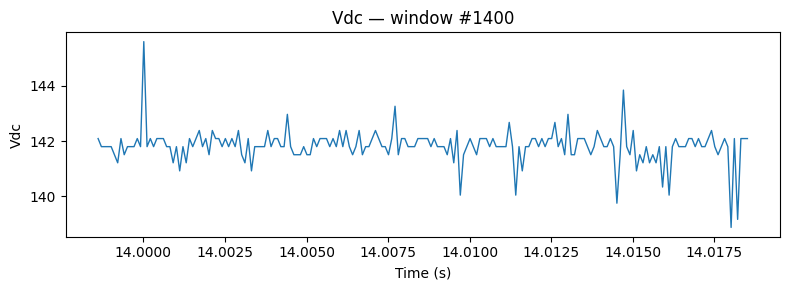

In [66]:

window_len, stride = 200, 100  # one cycle = 200 samples, 50% overlap


num_cols = [c for c in F0L.select_dtypes(include=[np.number]).columns if c != "Time"]
X = F0L[num_cols].values       # numeric matrix of features
t_all = F0L["Time"].values     # time vector


wins, starts = sliding_windows(X, window_len, stride)
print("windows:", wins.shape)  # [num_windows, window_len, num_features]


w_idx = 1400        # index of the window to visualize 
var = "Vdc"         # variable (column name) to visualize


j = num_cols.index(var)                 # column index of selected variable
s, e = starts[w_idx], starts[w_idx] + window_len  # time range for this window


plt.figure(figsize=(8,3))
plt.plot(t_all[s:e], wins[w_idx, :, j], lw=1)
plt.title(f"{var} — window #{w_idx}")
plt.xlabel("Time (s)")
plt.ylabel(var)
plt.tight_layout()
plt.show()

## PCA

In [ ]:
def apply_pca_safe(X, n_components_requested=9):
    X = np.asarray(X)
    n_samples, n_features = X.shape
    max_comp = min(n_samples, n_features)
    n_comp = max(1, min(int(n_components_requested), max_comp))
    if max_comp <= 1:
        # nothing to reduce meaningfully
        return X.reshape(n_samples, 1), None, 1
    pca = PCA(n_components=n_comp)
    Xp = pca.fit_transform(X)
    return Xp, pca, n_comp

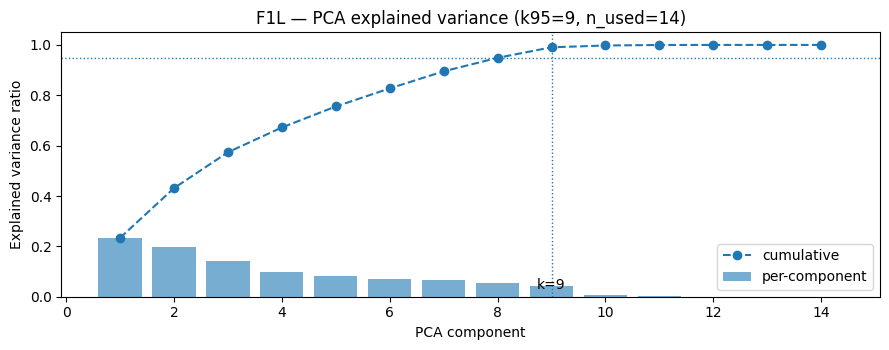

Min components for ≥95% variance: k = 9


In [ ]:
num_cols = [c for c in DF_z.select_dtypes(include=[np.number]).columns if c != "label"]
X = DF_z[num_cols].values


Xp, pca, n_used = apply_pca_safe(X, n_components_requested=min(20, X.shape[1]))

evr = pca.explained_variance_ratio_
cum = np.cumsum(evr)
k95 = int(np.searchsorted(cum, 0.95) + 1)  

xs = np.arange(1, len(evr) + 1)

 
plt.figure(figsize=(9, 3.6))
plt.bar(xs, evr, alpha=0.6, label="per-component")
plt.plot(xs, cum, marker="o", linestyle="--", label="cumulative")
plt.axhline(0.95, linestyle=":", linewidth=1)
plt.axvline(k95, linestyle=":", linewidth=1)
plt.text(k95, 0.02, f"k={k95}", ha="center", va="bottom")

plt.ylim(0, 1.05)
plt.xlabel("PCA component")
plt.ylabel("Explained variance ratio")
plt.title(f"{CURRENT} — PCA explained variance (k95={k95}, n_used={n_used})")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

print(f"Min components for ≥95% variance: k = {k95}")


## Feature aggregate

In [43]:
def aggregate_three_phase(df, i_cols=("ia","ib","ic"), v_cols=("va","vb","vc"),
                          method="rms", drop_original=False, prefix=""):
    
    out = df.copy()

    def combine(cols):
        cols = [c for c in cols if c in out.columns]
        if not cols:
            return None
        X = out[cols].values
        if method == "rms":     # magnitude-like representative
            return np.sqrt((X**2).mean(axis=1))
        elif method == "mean":  # simple average
            return X.mean(axis=1)
        elif method == "pca1":  # first principal component
            from sklearn.decomposition import PCA
            return PCA(n_components=1).fit_transform(X)[:, 0]
        else:
            raise ValueError("method must be 'rms', 'mean', or 'pca1'")

    iabc = combine(i_cols)
    vabc = combine(v_cols)
    if iabc is not None: out[prefix + "iabc"] = iabc
    if vabc is not None: out[prefix + "vabc"] = vabc

    if drop_original:
        out = out.drop(columns=[c for c in (*i_cols, *v_cols) if c in out.columns])

    return out


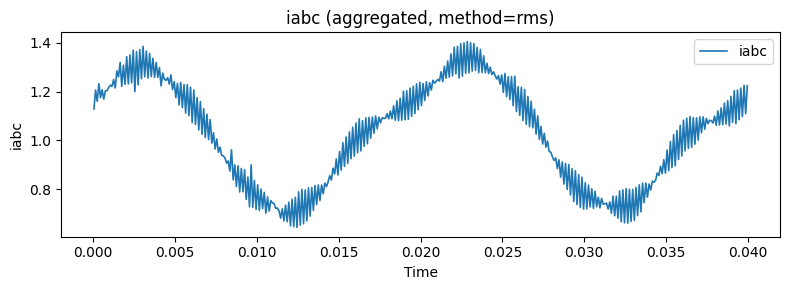

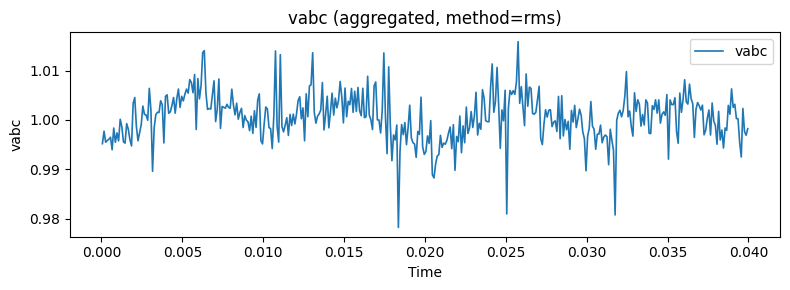

In [45]:
# 1) Build the aggregated DataFrame
DF_agg = aggregate_three_phase(DF_z, method="rms", drop_original=False)

# 2) Select points to show (reuse idx/x_sel if available, else make a simple fallback)
n = len(DF_agg)
if "idx" not in globals():
    N = min(400, n)
    idx = np.arange(N)
if "x_sel" not in globals():
    x_all = DF_agg["Time"].values if "Time" in DF_agg.columns else np.arange(n)
    x_sel = x_all[idx]

# 3) Plot the new features over time
for col in ["iabc", "vabc"]:
    if col in DF_agg.columns:
        y = DF_agg[col].values[idx]
        plt.figure(figsize=(8, 3))
        plt.plot(x_sel, y, lw=1.2, label=col)
        plt.xlabel("Time" if "Time" in DF_agg.columns else "Index")
        plt.ylabel(col)
        plt.title(f"{col} (aggregated, method=rms)")
        plt.legend()
        plt.tight_layout()
        plt.show()


